<a href="https://www.kaggle.com/code/amrsadek96/smartphone-price-prediction-r2-0-99?scriptVersionId=166518194" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#dataset link: https://www.kaggle.com/datasets/yaminh/smartphone-sale-dataset/data

2024-03-11 18:26:03.191988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 18:26:03.192097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 18:26:03.363364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/smartphone-sale-dataset/Sales.csv')

In [3]:
df.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8 GB,128 GB,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2 GB,16 GB,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
2,realme,C2,Diamond Black,2 GB,NaN,Yes,4.4,6999,7999,realme C2,1000,12.501563
3,Infinix,Note 5,Ice Blue,4 GB,64 GB,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4GB,64 GB,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brands               3114 non-null   object 
 1   Models               3114 non-null   object 
 2   Colors               3114 non-null   object 
 3   Memory               3071 non-null   object 
 4   Storage              3075 non-null   object 
 5   Camera               3114 non-null   object 
 6   Rating               2970 non-null   float64
 7   Selling Price        3114 non-null   int64  
 8   Original Price       3114 non-null   int64  
 9   Mobile               3114 non-null   object 
 10  Discount             3114 non-null   int64  
 11  discount percentage  3114 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 292.1+ KB


In [5]:
#Data missing in Rating,storage and Memory
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')

In [6]:
df['Storage'].value_counts()

Storage
64 GB                    774
128 GB                   764
32 GB                    555
16 GB                    322
256 GB                   240
8 GB                     133
512 GB                    67
4 GB                      56
2 MB                      45
4 MB                      28
16 MB                     14
1 TB                      14
128 MB                    12
Expandable Upto 32 GB     12
Expandable Upto 16 GB     12
8 MB                       6
64 MB                      3
129 GB                     3
256 MB                     3
48 MB                      3
512 MB                     2
130 GB                     2
100 MB                     2
153 MB                     1
10 MB                      1
140 MB                     1
Name: count, dtype: int64

In [7]:
#Splitting the column at the Space delimeter
df[['Storage Size', 'Storage Unit']] = df['Storage'].str.split(' ', n=1,expand=True)

In [8]:
df

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage,Storage Size,Storage Unit
0,SAMSUNG,GALAXY M31S,Mirage Black,8 GB,128 GB,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998,128,GB
1,Nokia,3.2,Steel,2 GB,16 GB,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000,16,GB
2,realme,C2,Diamond Black,2 GB,NaN,Yes,4.4,6999,7999,realme C2,1000,12.501563,NaN,NaN
3,Infinix,Note 5,Ice Blue,4 GB,64 GB,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000,64,GB
4,Apple,iPhone 11,Black,4GB,64 GB,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000,64,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,POCO,M4 Pro 5G,Cool Blue,6 GB,128 GB,Yes,4.4,16999,19999,POCO M4 Pro 5G,3000,15.000750,128,GB
3110,Nokia,225,Black,NaN,Expandable Upto 32 GB,Yes,3.6,3499,3499,Nokia 225,0,0.000000,Expandable,Upto 32 GB
3111,Apple,iPhone SE,White,2 GB,128 GB,Yes,4.5,44900,44900,Apple iPhone SE,0,0.000000,128,GB
3112,Apple,iPhone 13 Pro,Gold,6 GB,128 GB,Yes,NaN,119900,119900,Apple iPhone 13 Pro,0,0.000000,128,GB


In [9]:
#Defining function to add weights for storage

def weight(row):
    if row['Storage Unit'] == 'MB':
        return row['Storage Size']/1024
    elif row['Storage Unit'] == 'TB':
        return row['Storage Size'] * 1024
    else: 
        return row['Storage Size']
    
df['Storage Size'] = pd.to_numeric(df['Storage Size'],errors='coerce')
df['Adjusted Storage Size'] = df.apply(weight,axis=1)

In [10]:
df['Adjusted Storage Size'].value_counts()

Adjusted Storage Size
64.000000      774
128.000000     764
32.000000      555
16.000000      322
256.000000     240
8.000000       133
512.000000      67
4.000000        56
0.001953        45
0.003906        28
1024.000000     14
0.015625        14
0.125000        12
0.007812         6
0.062500         3
129.000000       3
0.250000         3
0.046875         3
0.500000         2
130.000000       2
0.097656         2
0.149414         1
0.009766         1
0.136719         1
Name: count, dtype: int64

In [11]:
#adding in place of the missing values and dropping the uneccessary columns
df['Adjusted Storage Size'] = imp.fit_transform(df['Adjusted Storage Size'].values.reshape(-1,1))
df = df.drop(['Storage','Storage Size','Storage Unit'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brands                 3114 non-null   object 
 1   Models                 3114 non-null   object 
 2   Colors                 3114 non-null   object 
 3   Memory                 3071 non-null   object 
 4   Camera                 3114 non-null   object 
 5   Rating                 2970 non-null   float64
 6   Selling Price          3114 non-null   int64  
 7   Original Price         3114 non-null   int64  
 8   Mobile                 3114 non-null   object 
 9   Discount               3114 non-null   int64  
 10  discount percentage    3114 non-null   float64
 11  Adjusted Storage Size  3114 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 292.1+ KB


In [12]:
#Checking the values in Memory
df['Memory'].value_counts()

Memory
4 GB      750
3 GB      498
6 GB      497
2 GB      390
8 GB      345
1 GB      193
4GB       137
12 GB      63
512 MB     46
4 MB       39
1.5 GB     29
16 MB      16
64 MB      15
8 MB       14
32 MB      14
768 MB      6
128 MB      4
10 MB       3
2 MB        2
46 MB       2
18 GB       2
16 GB       2
153 MB      1
30 MB       1
32 GB       1
100 MB      1
Name: count, dtype: int64

In [13]:
#Splitting the column at the Space delimeter
df[['Memory Size', 'Memory Unit']] = df['Memory'].str.split(' ', n=1,expand=True)



In [14]:
#Defining function to add weights for storage

def weight_Memory(row):
    if row['Memory Unit'] == 'MB':
        return row['Memory Size']/1024
    else: 
        return row['Memory Size']
    
    
df['Memory Size'] = pd.to_numeric(df['Memory Size'],errors='coerce')
df['Adjusted Memory Size'] = df.apply(weight_Memory,axis=1)

In [15]:
df['Adjusted Memory Size']

0       8.0
1       2.0
2       2.0
3       4.0
4       NaN
       ... 
3109    6.0
3110    NaN
3111    2.0
3112    6.0
3113    3.0
Name: Adjusted Memory Size, Length: 3114, dtype: float64

In [16]:
df['Adjusted Memory Size'] = imp.fit_transform(df['Adjusted Memory Size'].values.reshape(-1,1))

In [17]:
#Checking for the value counts
df = df.drop(['Memory Unit','Memory Size','Memory'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brands                 3114 non-null   object 
 1   Models                 3114 non-null   object 
 2   Colors                 3114 non-null   object 
 3   Camera                 3114 non-null   object 
 4   Rating                 2970 non-null   float64
 5   Selling Price          3114 non-null   int64  
 6   Original Price         3114 non-null   int64  
 7   Mobile                 3114 non-null   object 
 8   Discount               3114 non-null   int64  
 9   discount percentage    3114 non-null   float64
 10  Adjusted Storage Size  3114 non-null   float64
 11  Adjusted Memory Size   3114 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 292.1+ KB


In [18]:
#Checking the values of rating
df['Rating'].value_counts()

Rating
4.3    690
4.4    512
4.2    329
4.5    322
4.1    252
4.0    209
4.6    197
3.9    136
3.8    114
3.7     65
4.7     52
3.6     36
3.5     17
3.3      8
5.0      7
3.0      6
3.4      3
2.8      3
3.2      3
2.7      2
4.8      2
3.1      2
4.9      1
2.4      1
2.3      1
Name: count, dtype: int64

In [19]:
#using simple imputer to generate values instead of the missing ones
df['Rating'] = imp.fit_transform(df['Rating'].values.reshape(-1,1))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brands                 3114 non-null   object 
 1   Models                 3114 non-null   object 
 2   Colors                 3114 non-null   object 
 3   Camera                 3114 non-null   object 
 4   Rating                 3114 non-null   float64
 5   Selling Price          3114 non-null   int64  
 6   Original Price         3114 non-null   int64  
 7   Mobile                 3114 non-null   object 
 8   Discount               3114 non-null   int64  
 9   discount percentage    3114 non-null   float64
 10  Adjusted Storage Size  3114 non-null   float64
 11  Adjusted Memory Size   3114 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 292.1+ KB


In [20]:
#Checking the counts of brands for the purpose of lable encoding
df['Brands'].value_counts()

Brands
SAMSUNG         719
Apple           387
realme          327
OPPO            260
Nokia           213
Xiaomi          198
Infinix         151
GIONEE          129
vivo            124
Lenovo          121
ASUS            118
Motorola        105
LG               99
POCO             74
HTC              55
Google Pixel     29
IQOO              5
Name: count, dtype: int64

In [21]:
#Encoding Brands that have counts less
brand_counts = df['Brands'].value_counts()

def brand_encoder(brand):
    return 'other' if brand_counts[brand] < 150 else brand

df['Brands'] = df['Brands'].apply(brand_encoder)

In [22]:
df['Brands'].value_counts()

Brands
other      859
SAMSUNG    719
Apple      387
realme     327
OPPO       260
Nokia      213
Xiaomi     198
Infinix    151
Name: count, dtype: int64

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Brands'] = le.fit_transform(df['Brands'])
df['Brands'].value_counts()

Brands
6    859
4    719
0    387
7    327
3    260
2    213
5    198
1    151
Name: count, dtype: int64

In [24]:
df.head()

,Brands,Models,Colors,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage,Adjusted Storage Size,Adjusted Memory Size
0,4,GALAXY M31S,Mirage Black,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998,128.000000,8.000000
1,2,3.2,Steel,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000,16.000000,2.000000
2,7,C2,Diamond Black,Yes,4.4,6999,7999,realme C2,1000,12.501563,92.513777,2.000000
3,1,Note 5,Ice Blue,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000,64.000000,4.000000
4,0,iPhone 11,Black,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000,64.000000,4.137282


<Axes: >

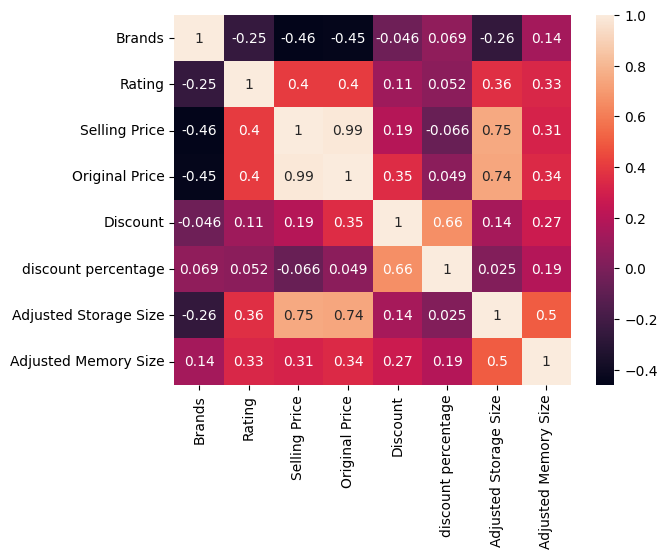

In [25]:
sns.heatmap(df.drop(['Models','Colors','Mobile','Camera'],axis=1).corr(),annot=True)

In [26]:
df['Models'] = le.fit_transform(df['Models'])
df['Colors'] = le.fit_transform(df['Colors'])

In [27]:
df['Camera'] = df['Camera'].apply(lambda x: 1 if x=='Yes' else 0)

In [28]:
df.head()

,Brands,Models,Colors,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage,Adjusted Storage Size,Adjusted Memory Size
0,4,285,356,1,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998,128.000000,8.000000
1,2,45,562,1,3.8,10199,10199,Nokia 3.2,0,0.000000,16.000000,2.000000
2,7,171,174,1,4.4,6999,7999,realme C2,1000,12.501563,92.513777,2.000000
3,1,583,270,1,4.2,12999,12999,Infinix Note 5,0,0.000000,64.000000,4.000000
4,0,886,46,1,4.6,49900,49900,Apple iPhone 11,0,0.000000,64.000000,4.137282


<Axes: >

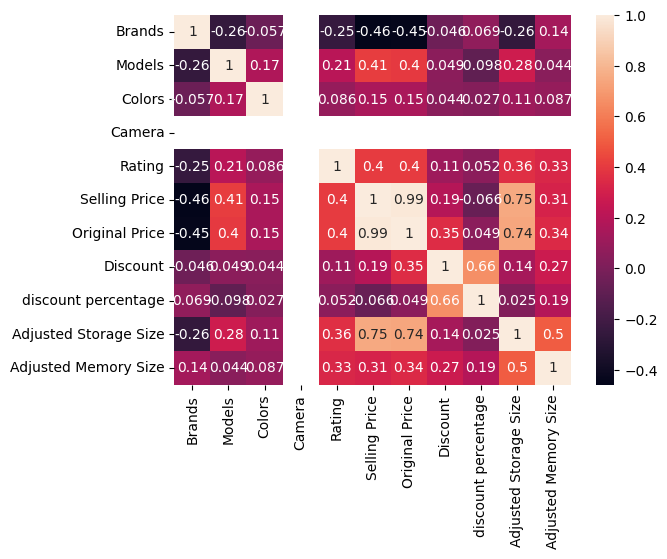

In [29]:
sns.heatmap(df.drop('Mobile',axis=1).corr(),annot=True)

In [30]:
df = df.drop(['Camera','Mobile'],axis=1)

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [32]:
x = df.drop(['Selling Price'],axis=1)
y = df['Selling Price']

In [33]:
X_train,X_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=42)

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.fit_transform(X_test)

In [35]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_tr = lr.predict(X_train)

In [36]:
from sklearn.metrics import r2_score
r2_tr = r2_score(y_train,y_pred_tr)
r2_tr

1.0

In [37]:
y_pred_te = lr.predict(X_test)
r2_te = r2_score(y_test,y_pred_te)
print(f"r2 Score={r2_te}")

r2 Score=0.9991925729169506


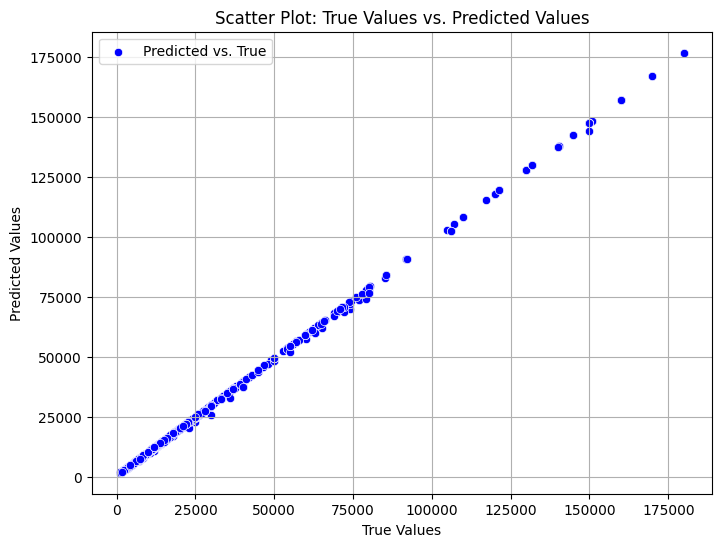

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_te, color='blue', label='Predicted vs. True')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: True Values vs. Predicted Values')
plt.grid(True)
plt.show()